In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import random
import csv
import math
import statistics
import os
import os.path
from os import path
import time

random.seed(2)
np.random.seed(2)

In [2]:
# set home dir
os.chdir('..//..//')
os.getcwd();

In [3]:
# Out_dir is where you want all of the program output to be. The code will make subfolders for you nicely!
out_dir = 'other//no_meta'
# Data_dir is where all of the stock data is
data_dir = "Data//Stocks_Sector_CC"

days_total = 60
window_size = 10
num_iter_test = 50

num_tasks = 45
epochs = 1000
# Should be 1 for meta-learning
num_iter_meta = 1

sample_size = 10

days_train = int(days_total * 0.7)

In [4]:
def writeCSV(directory, out_type, data):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Create subfolders and assign variables based on output type
    if(out_type in ["meta_data","train_data","profit_data","results_data"]):
        if(out_type == "meta_data"):
            folder = out_dir + "/meta"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Epoch","Reward"]
       
        if(out_type == "results_data"):
            folder = out_dir + "/final_results"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Sample","Total Profit"]

        if(out_type == "train_data"):
            folder = (out_dir 
                      + "/trading_stats/" 
                      + "trading" 
                      + ident_fill 
                      + '/train')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Iteration","Reward"]

        if(out_type == "profit_data"):
            folder = (out_dir + "/trading_stats/" + "trading" + ident_fill + '/trade_balance')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Day","Profit"]
            
        fileName = (folder + '/' + 'no_meta_' + out_type + ident_fill + " - {}.csv")
        
        # Save file with incremented ending
        i = 1
        while(path.exists(fileName.format(i))):
            i += 1
        saveFile = fileName.format(i)
        
        # Write to csv file with cols as headers, integer indicies, and data
        with open(saveFile, mode='x', newline='') as test_file:
            test_writer = csv.writer(test_file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
            test_writer.writerow(cols)
            for i,j in zip(data,range(0, len(data))):
                test_writer.writerow([str(j), str(i)])
        test_file.close()

    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta_data\'\n' 
                        + '\'train_data\'\n' 
                        + '\'profit_data\'\n'
                        + '\'results_data\'\n')

    
def saveFig(directory, out_type):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Make folders in out_dir and set paths
    folder_final_results = directory + '/final_results' 
    folder_meta = directory + '/meta'
    folder_trading_stats = directory + '/trading_stats'
    if(not path.exists(folder_final_results)):
        os.mkdir(folder_final_results)
    if(not path.exists(folder_meta)):
        os.mkdir(folder_meta)
    if(not path.exists(folder_trading_stats)):
        os.mkdir(folder_trading_stats)
    
    trade_path = folder_trading_stats + '/' + 'trading' + ident_fill
    trade_path2 = trade_path + '/' + out_type    
    
    # Add files to folders
    filename = ""
    
    if(out_type in ['trading','trade_balance','test_stock', 'train']):
        if(not path.exists(trade_path)):
            os.mkdir(trade_path)
        if(out_type != 'test_stock'):
            if(not path.exists(trade_path2)):
                os.mkdir(trade_path2)
            fileName = trade_path2 + '/' + 'no_meta_' + out_type + ident_fill    
        
        elif(out_type == 'test_stock'):
            fileName = trade_path + '/' + 'no_meta_' + out_type + ident_fill
            
    elif(out_type == 'meta'):
        fileName = folder_meta + '/' + 'no_meta_' + out_type + ident_fill
       
    elif(out_type == 'results'):
        fileName = folder_final_results + '/' + 'no_meta_' + out_type + ident_fill
    
    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta\'\n' 
                        + '\'results\'\n' 
                        + '\'trading\'\n' 
                        + '\'trade_balance\'\n' 
                        + '\'out_typeset\'\n' 
                        + '\'train\'\n')
    
    filename = filename + ' - {}.png'
    i = 1
    while(path.exists(fileName.format(i))):
        i += 1
    plt.savefig(fileName.format(i))

In [5]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [6]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
                
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 0.0001)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])                   
                
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * (np.dot(A.T, rewards).T + 0.0001)
                )
                
            epoch_rewards.append(self.reward_function(self.weights))

In [7]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
import time

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.3
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.profit = 0
        
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        
    def get_profit(self):
        return self.profit
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):        
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy                
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity                
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
            state = next_state
        return ((initial_money - starting_money) / (starting_money + 0.0001)) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
       
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        track_money.append(initial_money - starting_money)
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
                
                track_money.append(initial_money - starting_money)
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                track_money.append(initial_money - starting_money)
                
            else:
                track_money.append(initial_money - starting_money)
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        self.profit = initial_money - starting_money
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        
        plt.figure(figsize = (20, 10))
        plt.title("Base NES Trading")
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        saveFig(out_dir, 'trading')
        plt.show()

In [9]:
# Retrieve datasets
datasetNames = []
allDatasets = []
for root,dirs,files in os.walk(data_dir):
    for file in files:
        if file.endswith("_New.csv"):
            datasetNames.append(file)
            dataset = pd.read_csv(data_dir + "\\" + file)
            allDatasets.append((file,dataset[:days_total]))

#sSet up model
input_size_g = window_size
layer_size_g = 500
output_size_g = 3
model = Model(input_size = input_size_g, layer_size = layer_size_g, output_size = output_size_g)

#initialize meta-weights as random
feed_w1 = np.random.randn(input_size_g, layer_size_g)
decision_w2 = np.random.randn(layer_size_g, output_size_g)
buy_w3 = np.random.randn(layer_size_g, 1)
feed_w4 = np.random.randn(1, layer_size_g)

In [10]:
# Pick datasets that start at Jan 2, 2001
datasets = []
for i in allDatasets:
    if(i[1]["Unnamed: 0"][0] == '1/2/2001'):
        datasets.append(i)
    else:
        print("Excluded from dataset:",i[0])
        
if(num_tasks > (len(datasets) - 1)):
    raise Exception('num_tasks = ' + str(num_tasks) + ', but there are only ' + str(len(datasets)) + ' datasets!')

Excluded from dataset: DG_New.csv
Excluded from dataset: NLSN_New.csv
Excluded from dataset: PFG_New.csv
Excluded from dataset: PM_New.csv
Excluded from dataset: TDC_New.csv


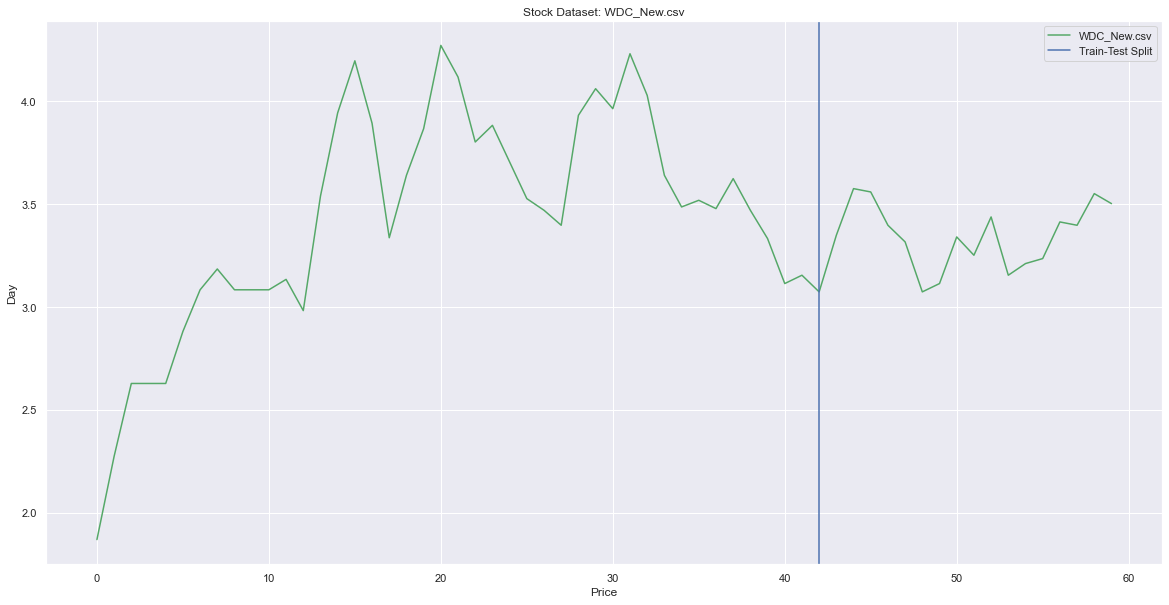

In [11]:
days_test = days_total - days_train

# Split test stage into train and test
test = datasets[-1]
test_dataset = datasets[-1][1]
t_train = test_dataset[:days_train] 
t_test = test_dataset[days_train:days_total]

c = test_dataset.Close.values.tolist()

# Test stock plot
plt.figure(figsize = (20, 10))
plt.title("Stock Dataset: " + test[0])
plt.xlabel('Price')
plt.ylabel('Day')
plt.plot(c, label = test[0], c = 'g')
plt.axvline(x=days_train, label = 'Train-Test Split')
plt.ticklabel_format(style='plain')
plt.legend()

saveFig(out_dir, 'test_stock')
plt.show()

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 13: buy 1 units at price 3.235503, total balance 9996.392414
day 14: buy 1 units at price 3.413455, total balance 9992.978959
day 15: buy 1 units at price 3.397277, total balance 9989.581682
day 16: buy 1 units at price 3.550965, total balance 9986.030717

total gained -13.969283, total investment -0.139693 %


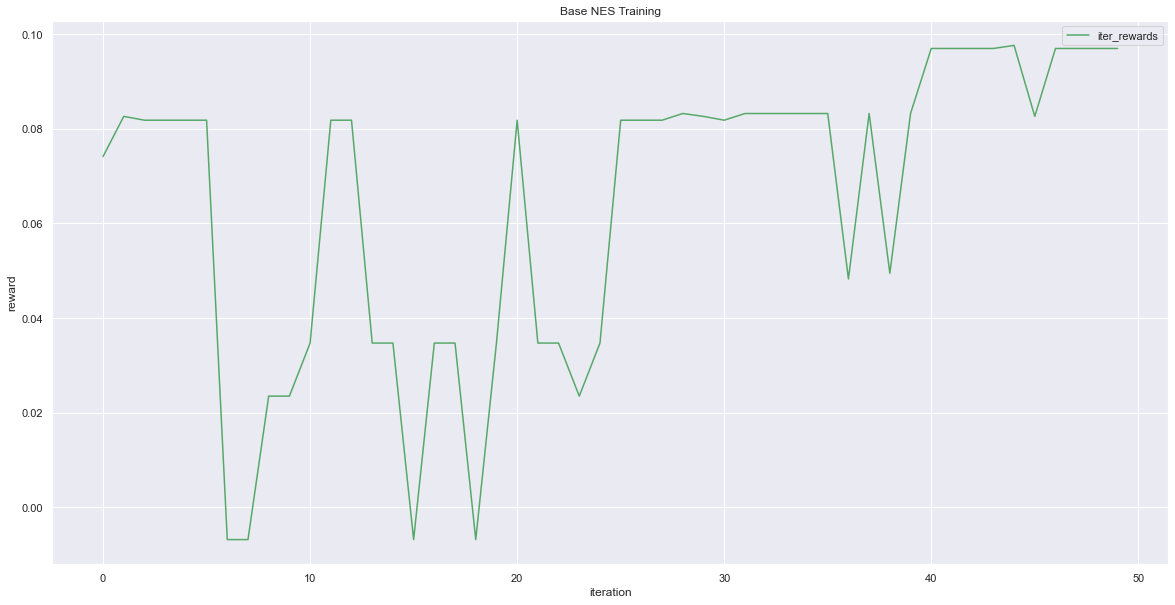

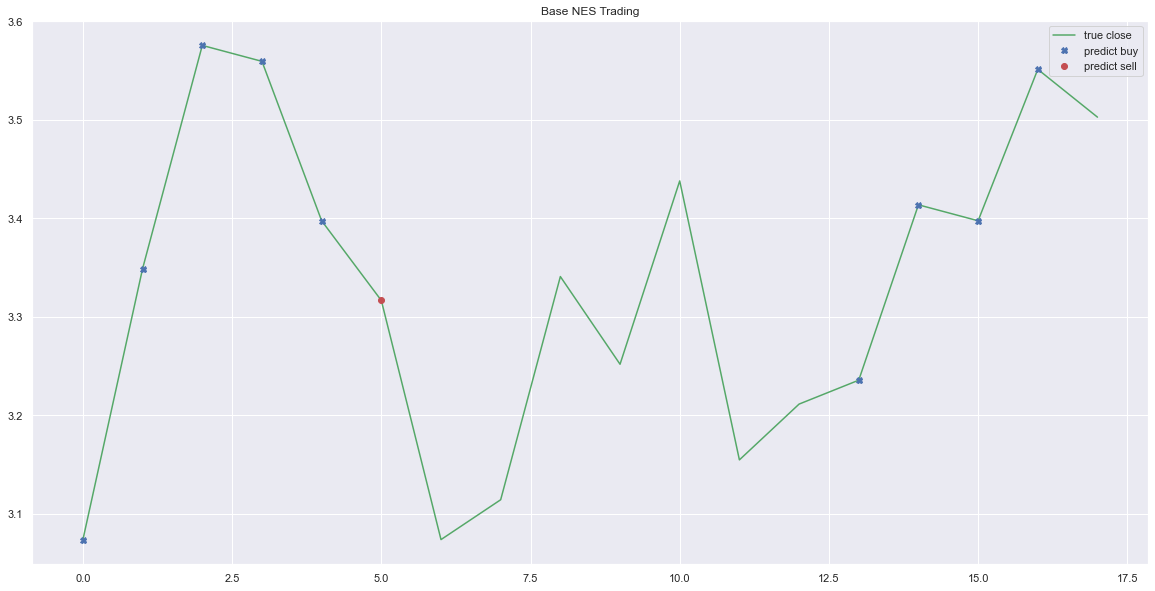

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5: buy 1 units at price 3.316390, total balance 9979.729577
day 6: buy 1 units at price 3.073728, total balance 9976.655849
day 7: buy 1 units at price 3.114171, total balance 9973.541678
day 8: buy 1 units at price 3.340657, total balance 9970.201021
day 9: buy 1 units at price 3.251680, total balance 9966.949341
day 10: buy 1 units at price 3.437722, total balance 9963.511619
day 11, sell 5 units at price 15.773075, investment 413.157801 %, total balance 9979.284694,
day 12: buy 1 units at price 3.211236, total balance 9976.073458
day 13: buy 1 units at price 3.235503, total balance 9972.837955
day 14: buy 1 units at price 3.413455, total balance 9969.424500
day 15:

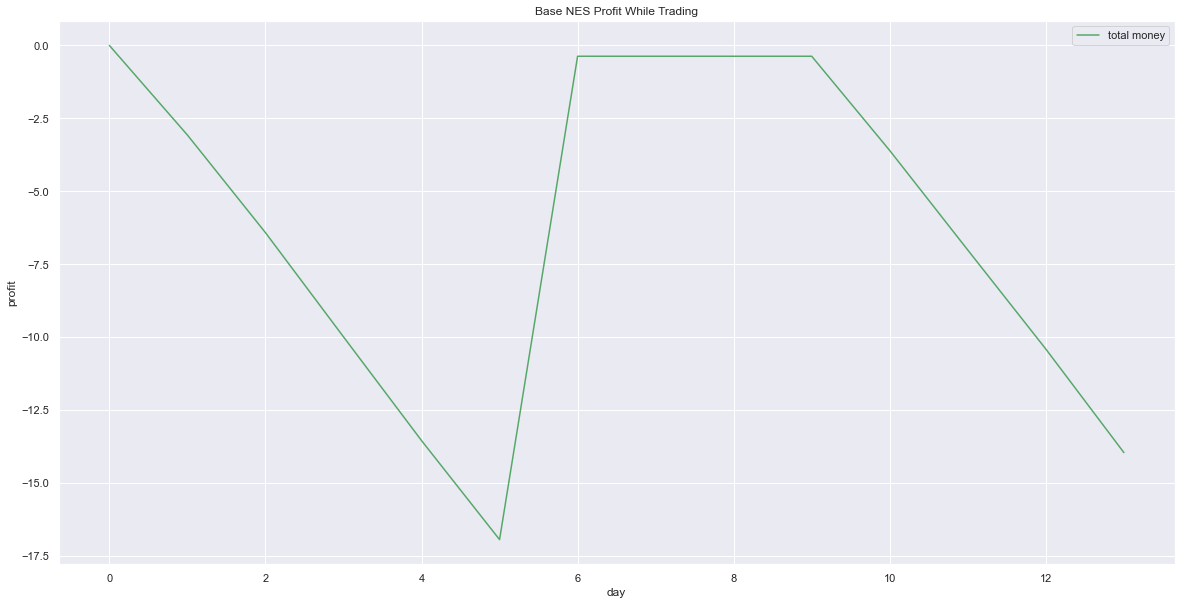

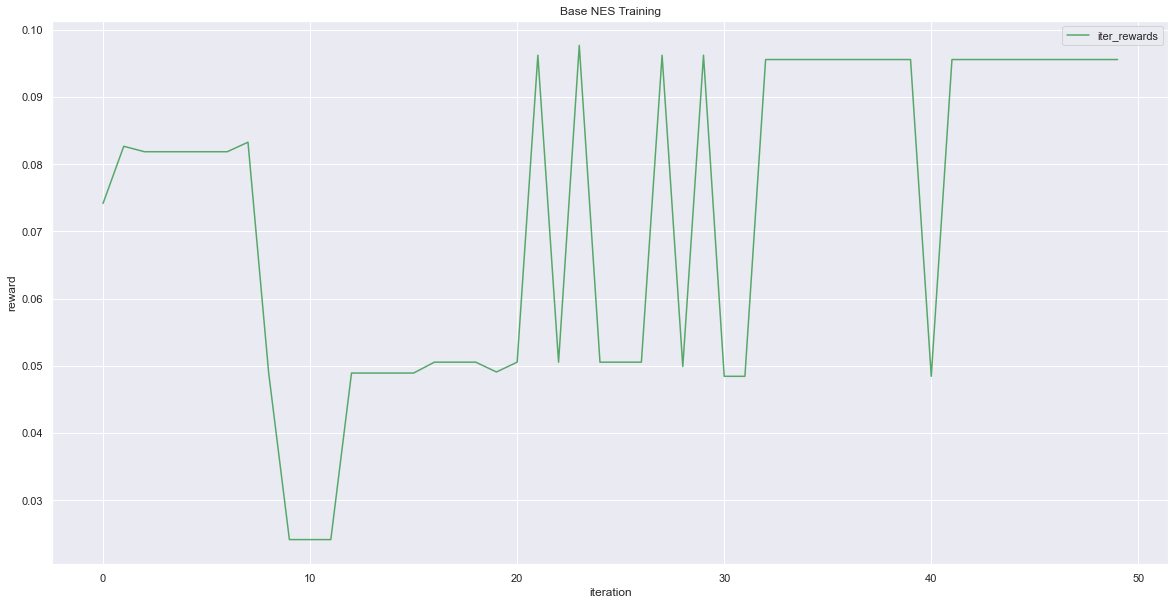

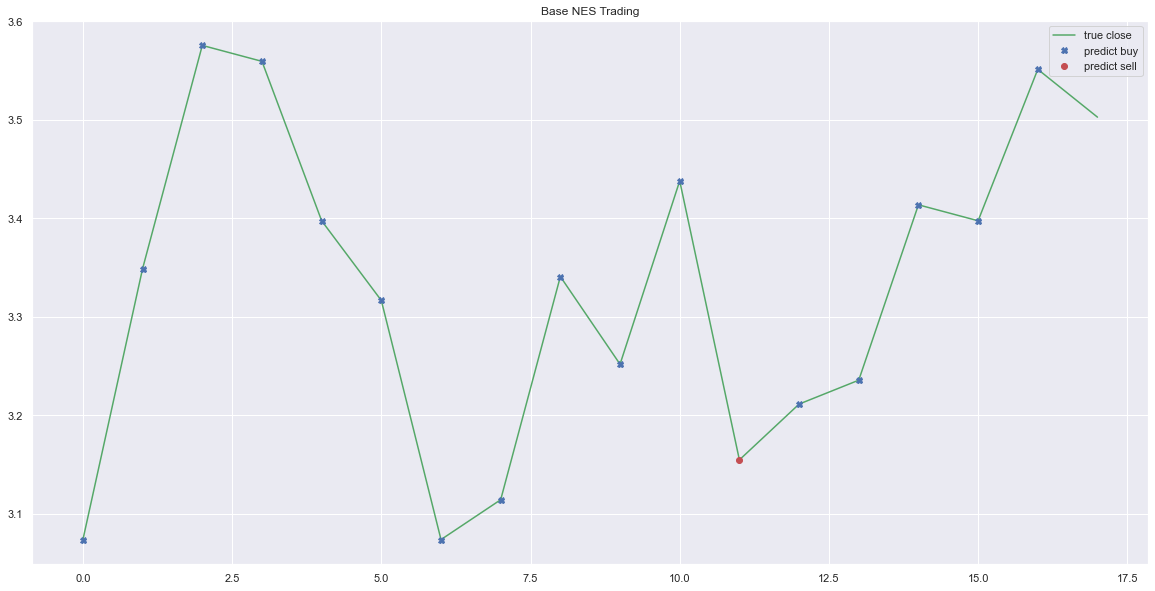

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4, sell 4 units at price 13.589108, investment 342.105092 %, total balance 10000.032352,
day 9: buy 1 units at price 3.251680, total balance 9996.780672
day 10: buy 1 units at price 3.437722, total balance 9993.342950
day 11, sell 2 units at price 6.309230, investment 94.029855 %, total balance 9999.652180,
day 14: buy 1 units at price 3.413455, total balance 9996.238725
day 15: buy 1 units at price 3.397277, total balance 9992.841448
day 16: buy 1 units at price 3.550965, total balance 9989.290483

total gained -10.709517, total investment -0.107095 %


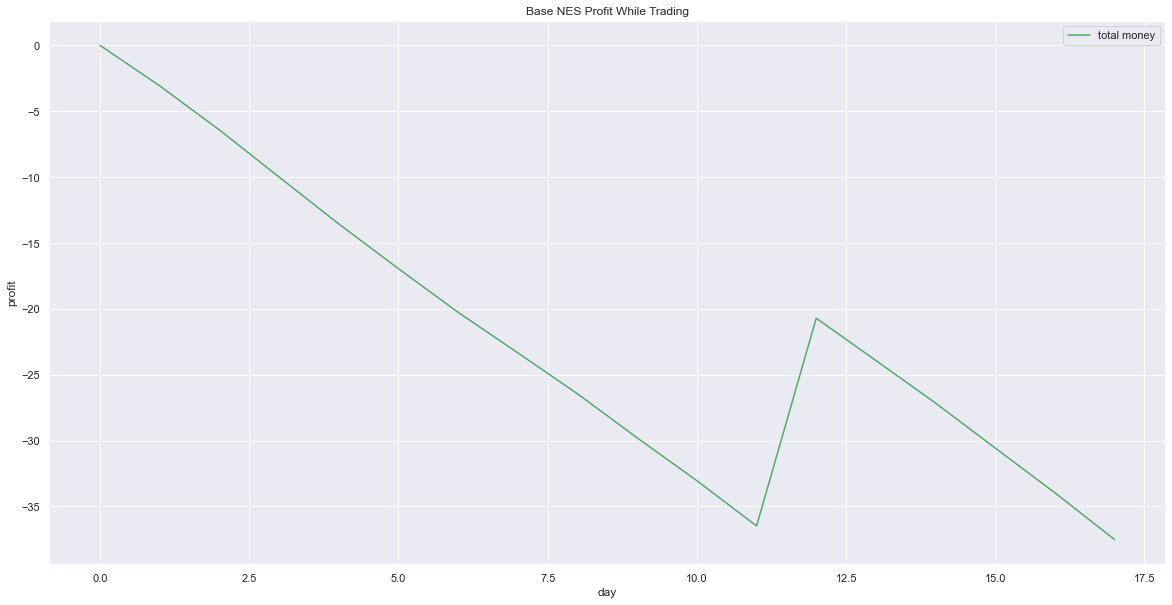

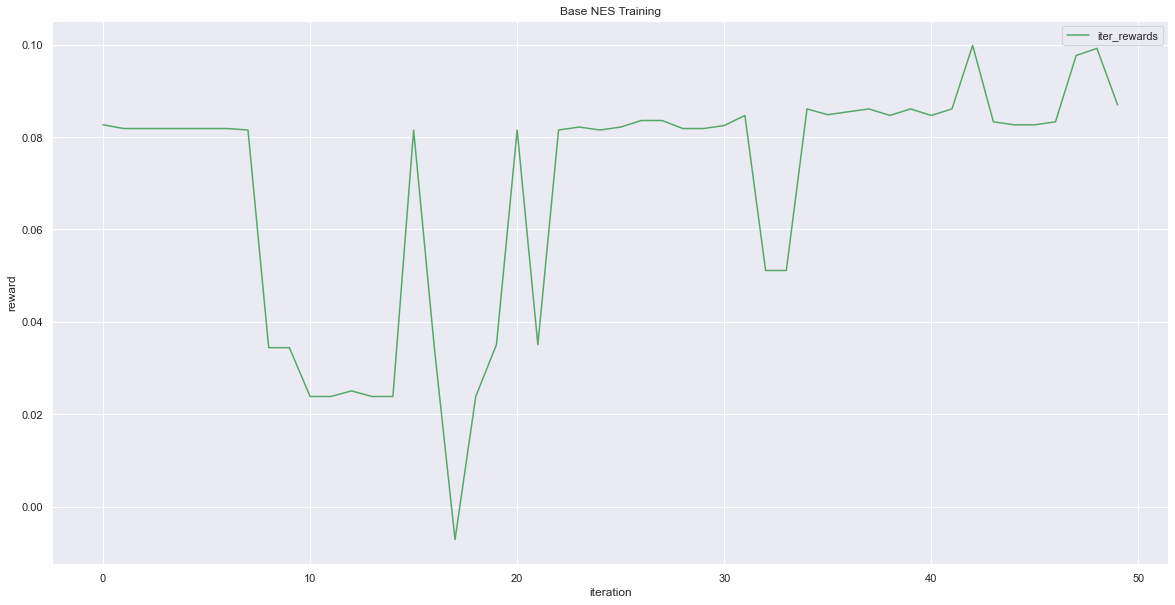

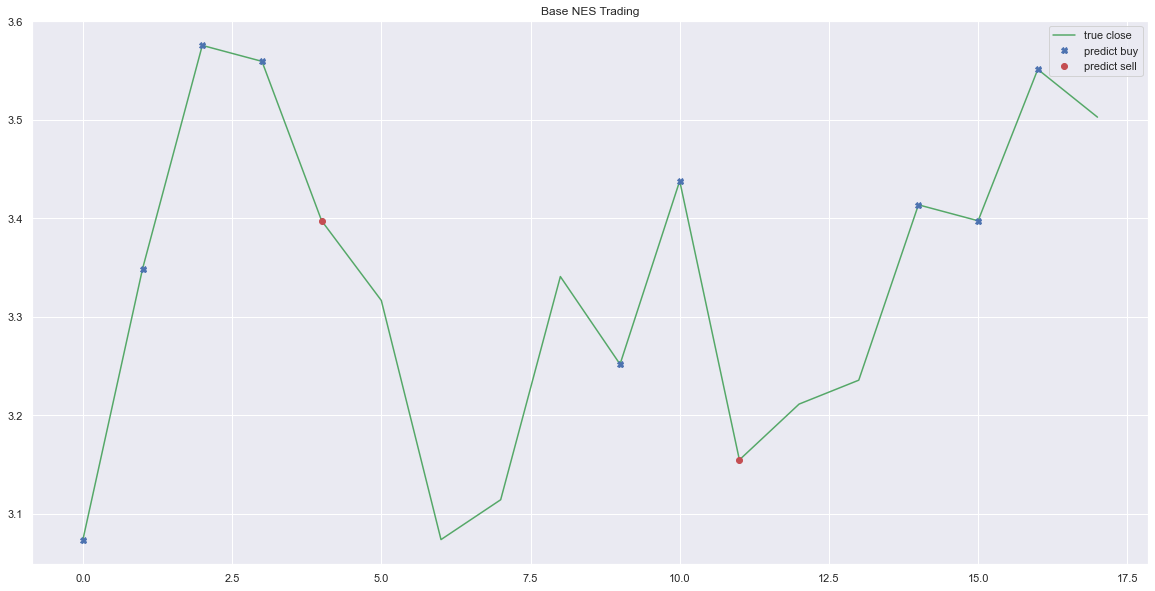

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 13: buy 1 units at price 3.235503, total balance 9996.392414
day 14: buy 1 units at price 3.413455, total balance 9992.978959
day 15: buy 1 units at price 3.397277, total balance 9989.581682
day 16: buy 1 units at price 3.550965, total balance 9986.030717

total gained -13.969283, total investment -0.139693 %


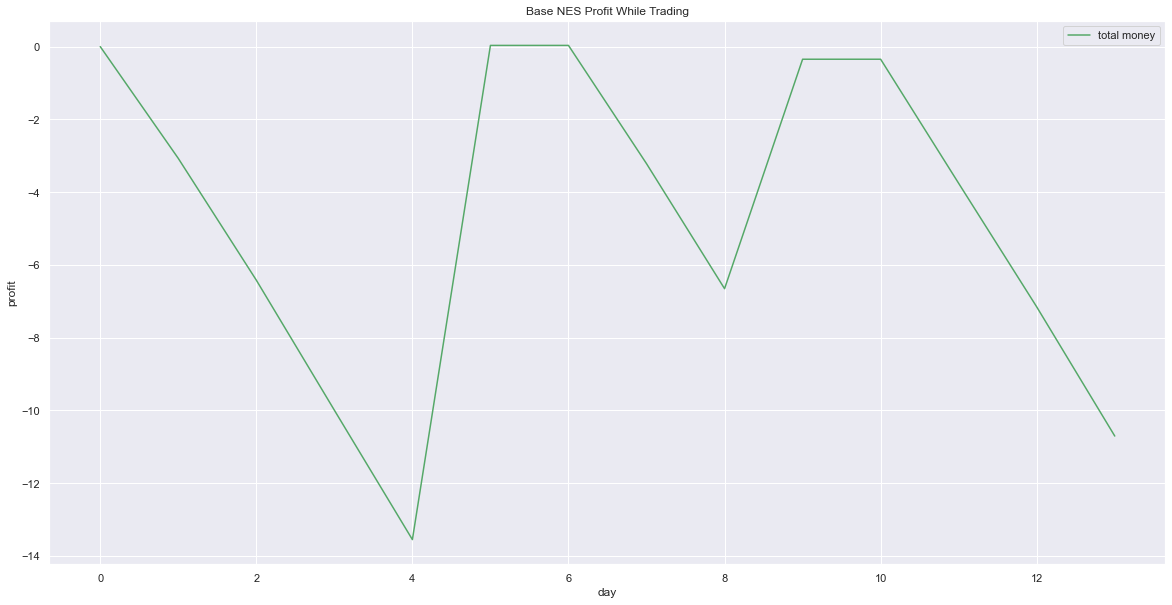

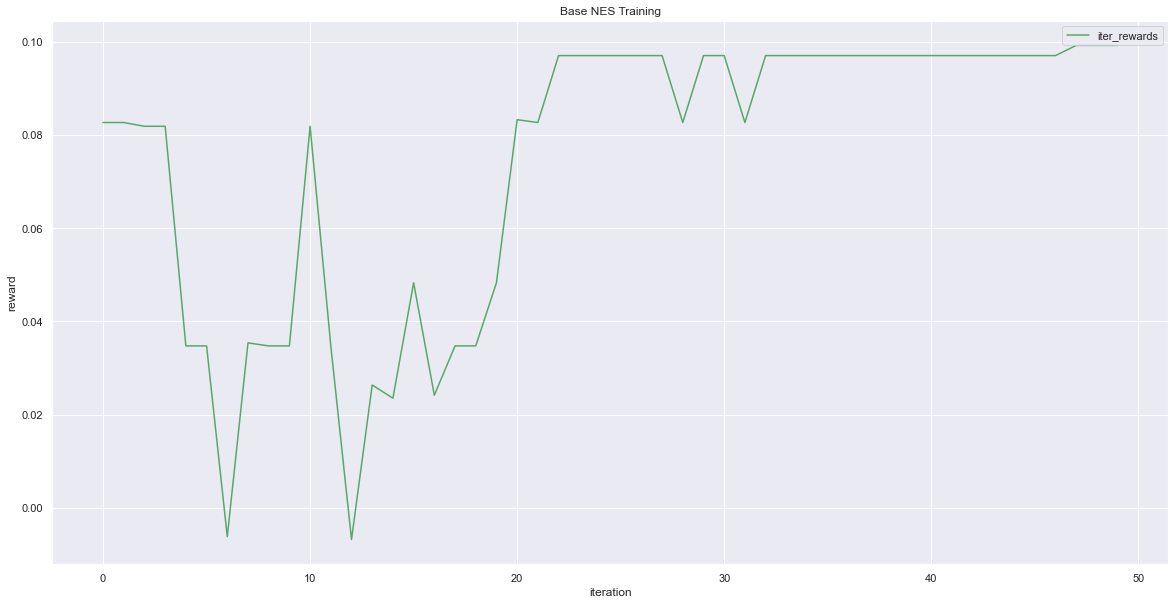

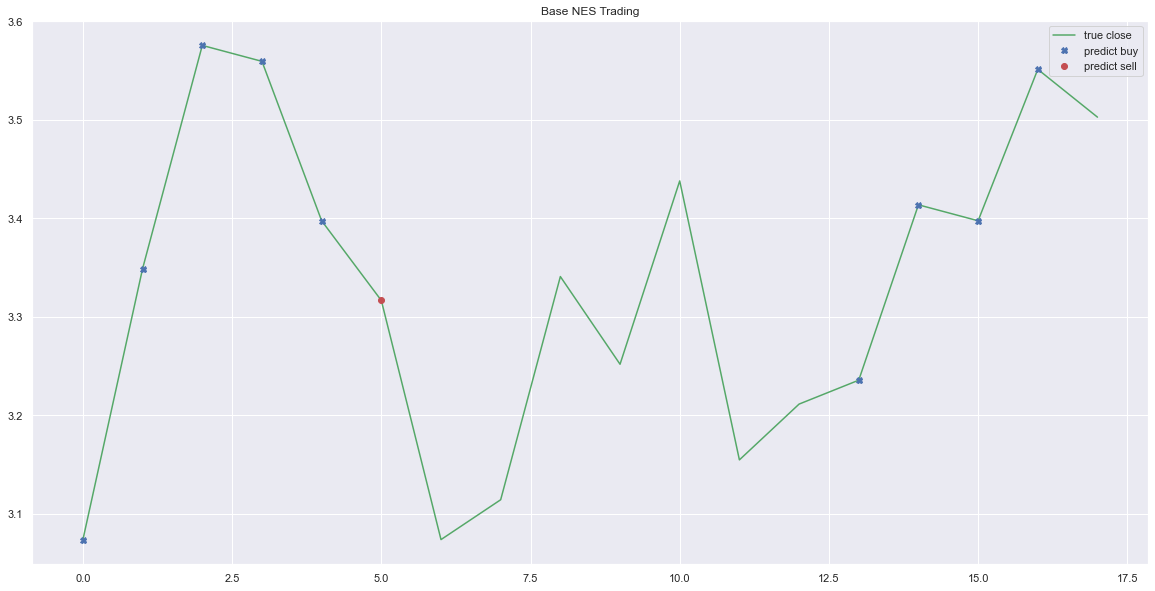

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 12: buy 1 units at price 3.211236, total balance 9996.416681
day 13: buy 1 units at price 3.235503, total balance 9993.181178
day 14: buy 1 units at price 3.413455, total balance 9989.767723
day 15: buy 1 units at price 3.397277, total balance 9986.370446
day 16: buy 1 units at price 3.550965, total balance 9982.819481

total gained -17.180519, total investment -0.171805 %


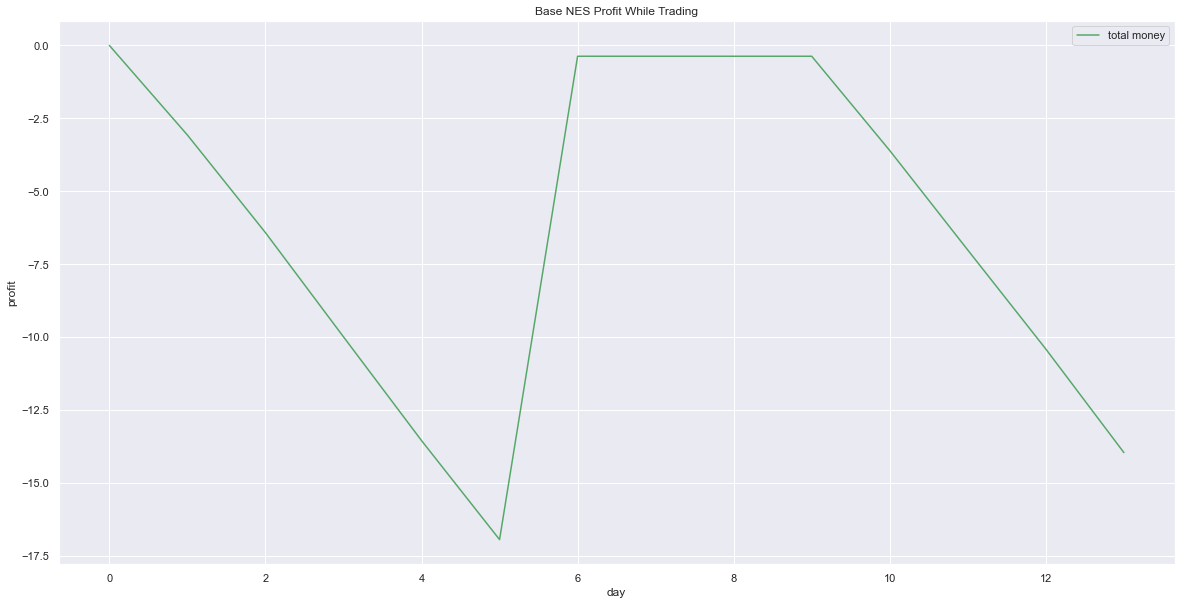

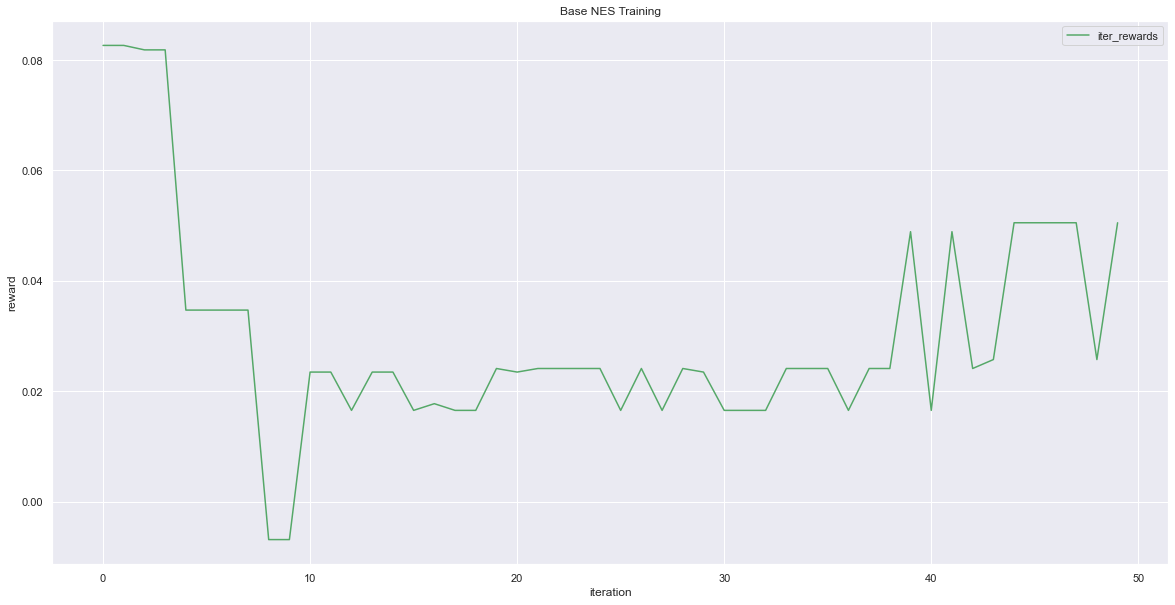

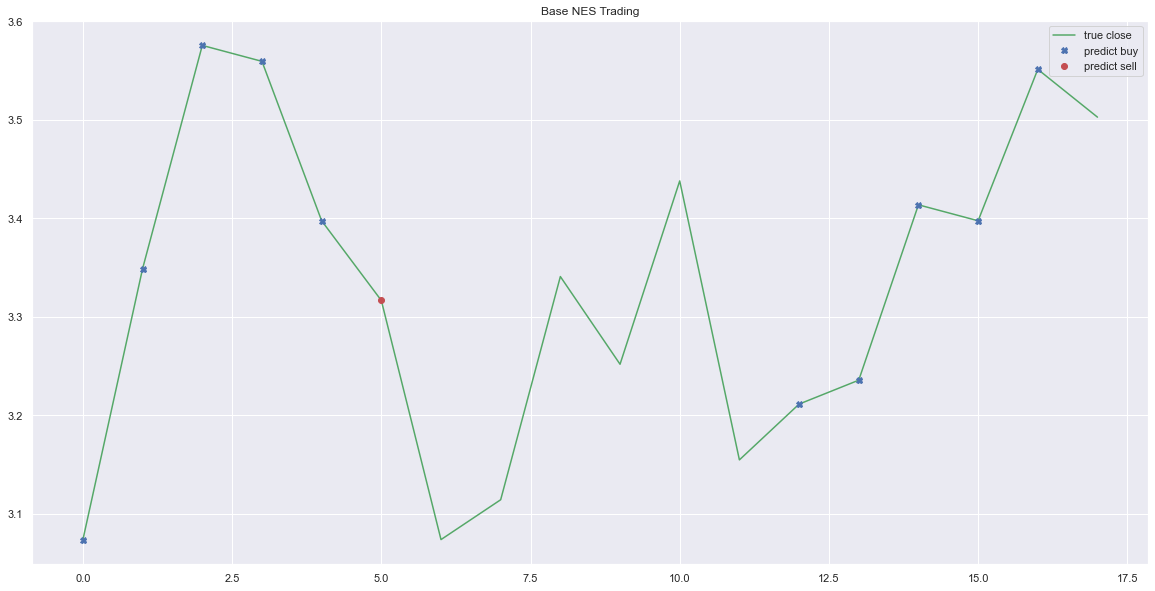

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 6: buy 1 units at price 3.073728, total balance 9996.554189
day 7: buy 1 units at price 3.114171, total balance 9993.440018
day 8: buy 1 units at price 3.340657, total balance 9990.099361
day 9: buy 1 units at price 3.251680, total balance 9986.847681
day 10: buy 1 units at price 3.437722, total balance 9983.409959
day 11, sell 5 units at price 15.773075, investment 371.014514 %, total balance 9999.183034,
day 12: buy 1 units at price 3.211236, total balance 9995.971798
day 13: buy 1 units at price 3.235503, total balance 9992.736295
day 14: buy 1 units at price 3.413455, total

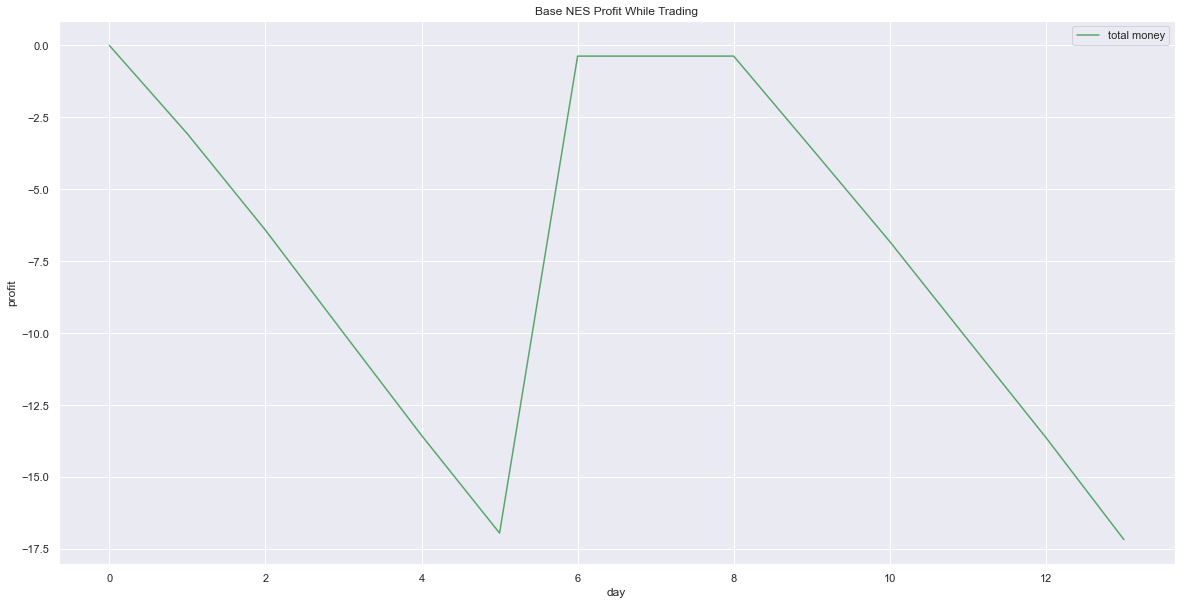

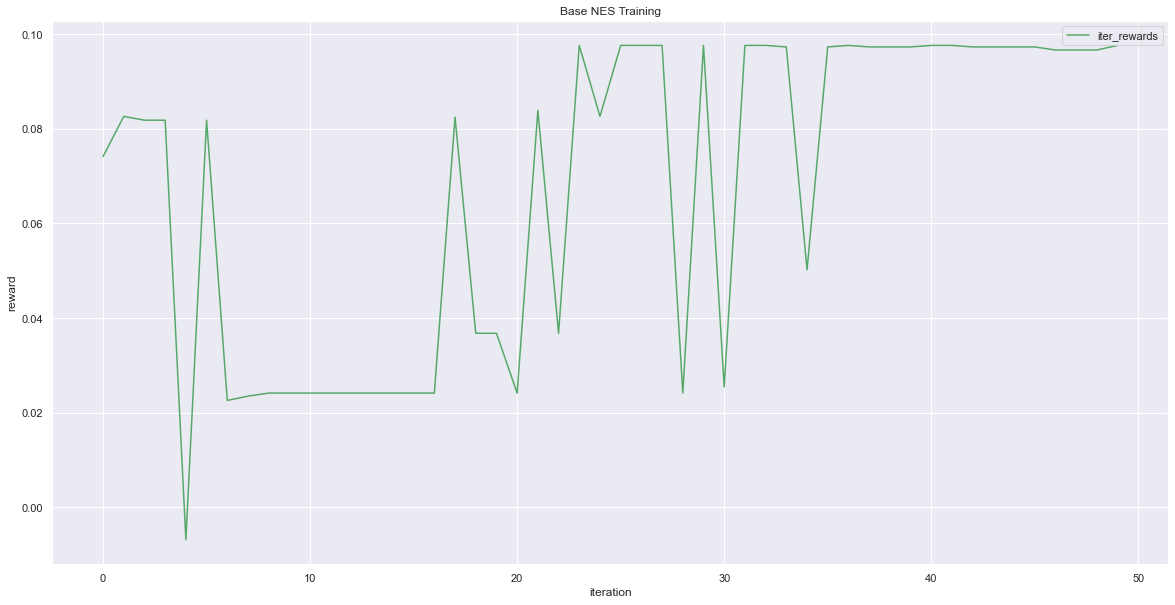

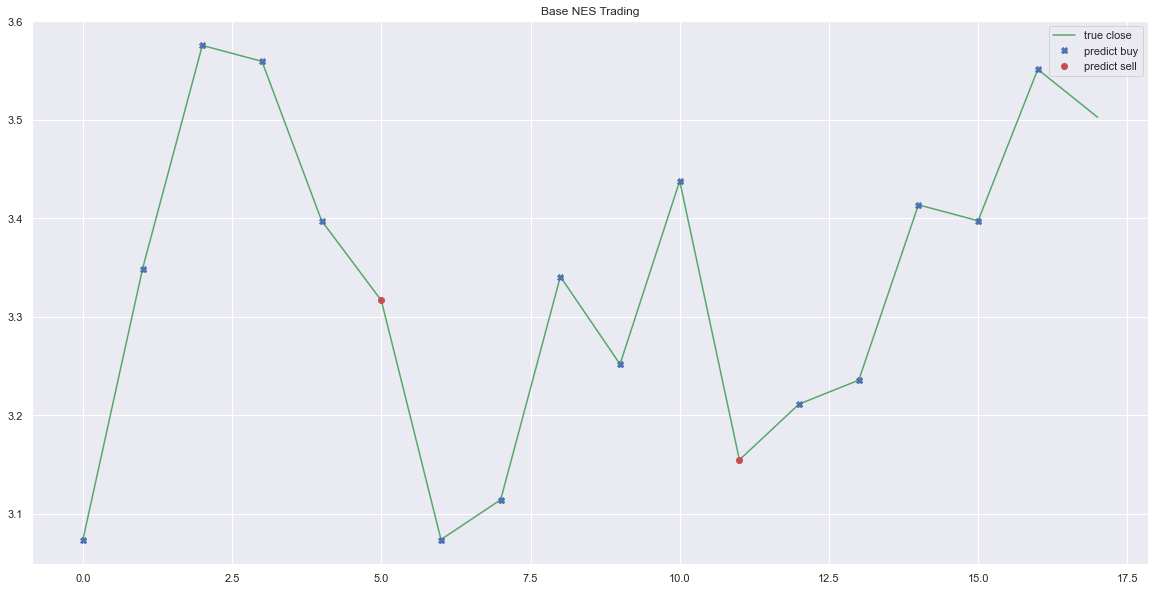

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 12: buy 1 units at price 3.211236, total balance 9996.416681
day 13: buy 1 units at price 3.235503, total balance 9993.181178
day 14: buy 1 units at price 3.413455, total balance 9989.767723
day 15: buy 1 units at price 3.397277, total balance 9986.370446
day 16: buy 1 units at price 3.550965, total balance 9982.819481

total gained -17.180519, total investment -0.171805 %


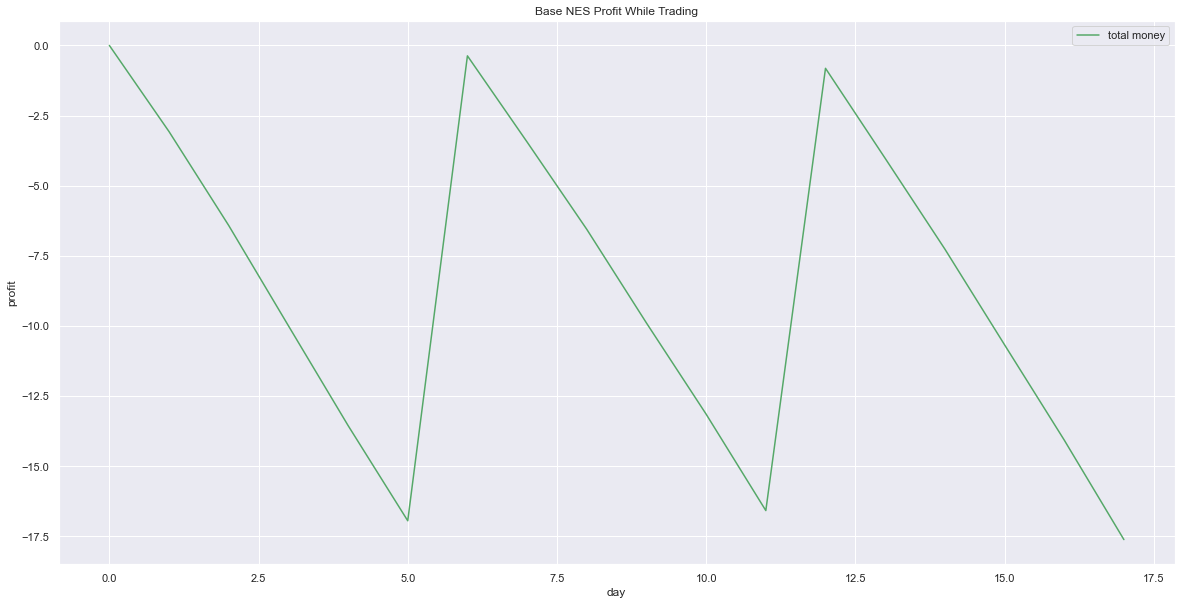

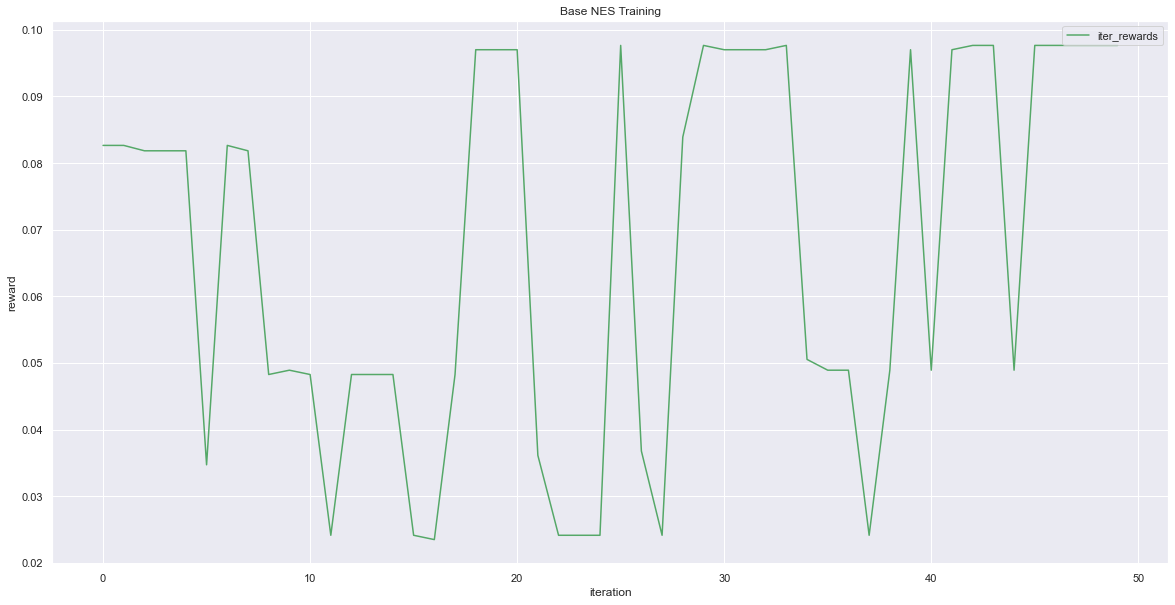

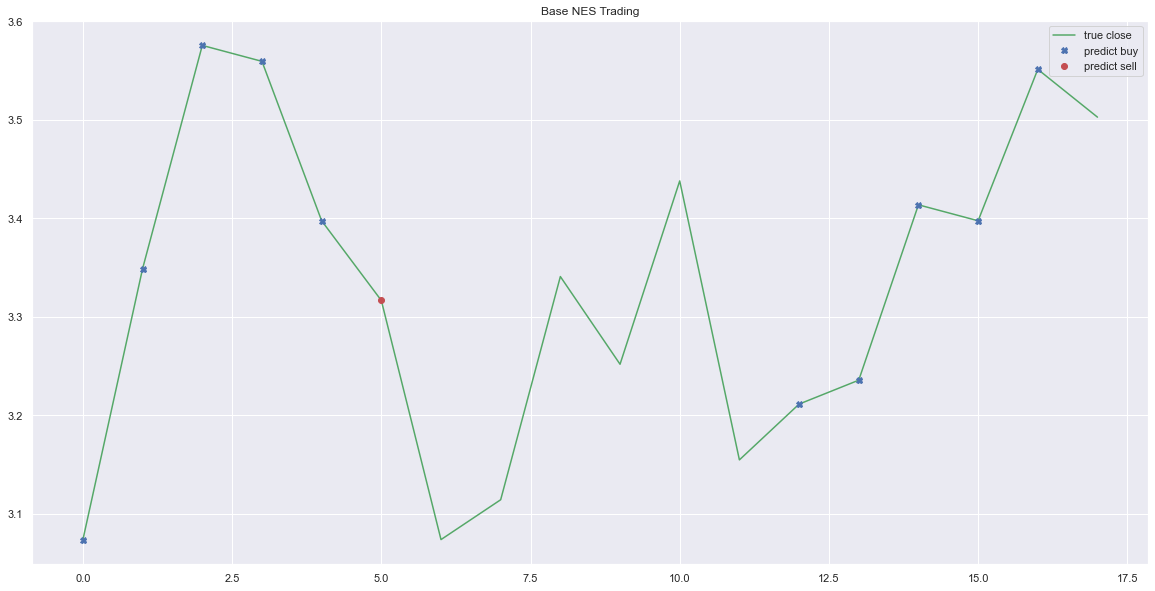

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4, sell 4 units at price 13.589108, investment 342.105092 %, total balance 10000.032352,
day 9: buy 1 units at price 3.251680, total balance 9996.780672
day 10: buy 1 units at price 3.437722, total balance 9993.342950
day 11, sell 2 units at price 6.309230, investment 94.029855 %, total balance 9999.652180,
day 14: buy 1 units at price 3.413455, total balance 9996.238725
day 15: buy 1 units at price 3.397277, total balance 9992.841448
day 16: buy 1 units at price 3.550965, total balance 9989.290483

total gained -10.709517, total investment -0.107095 %


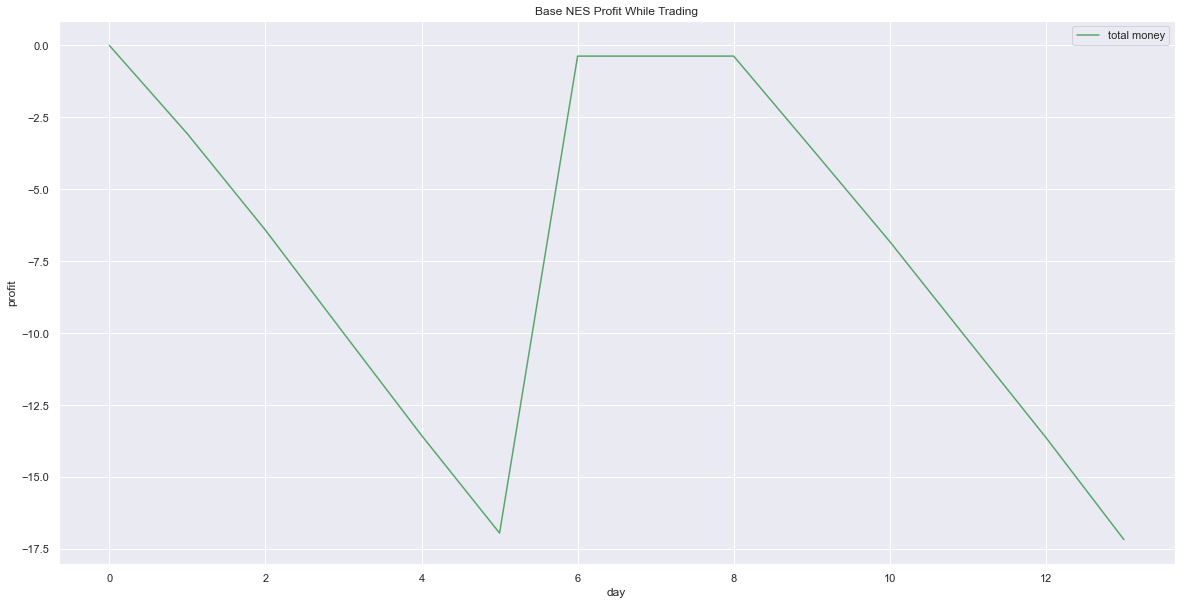

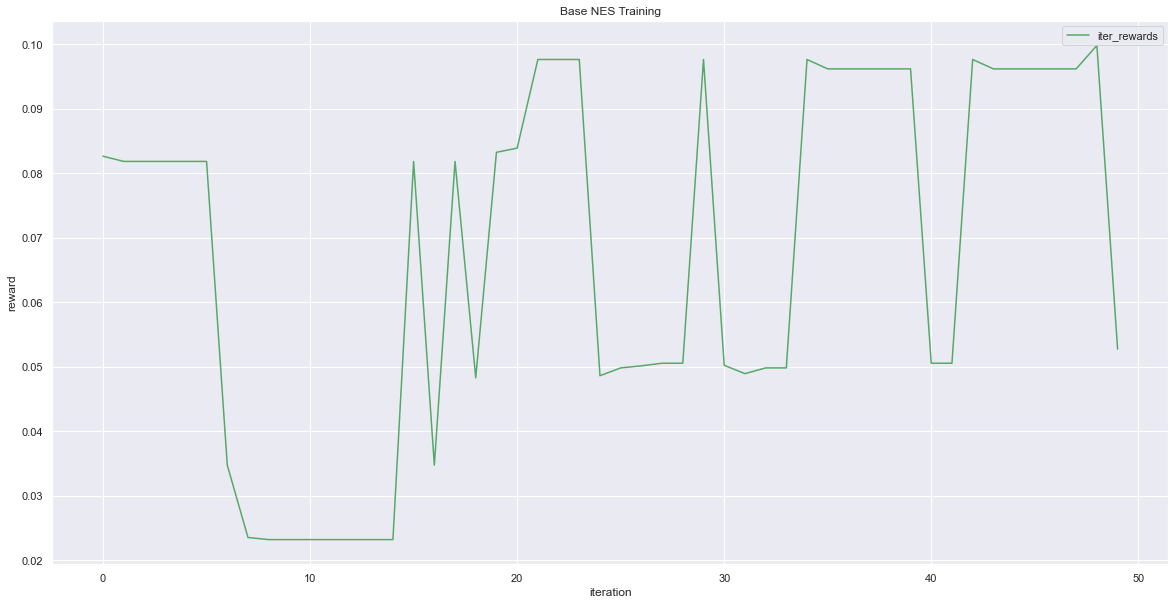

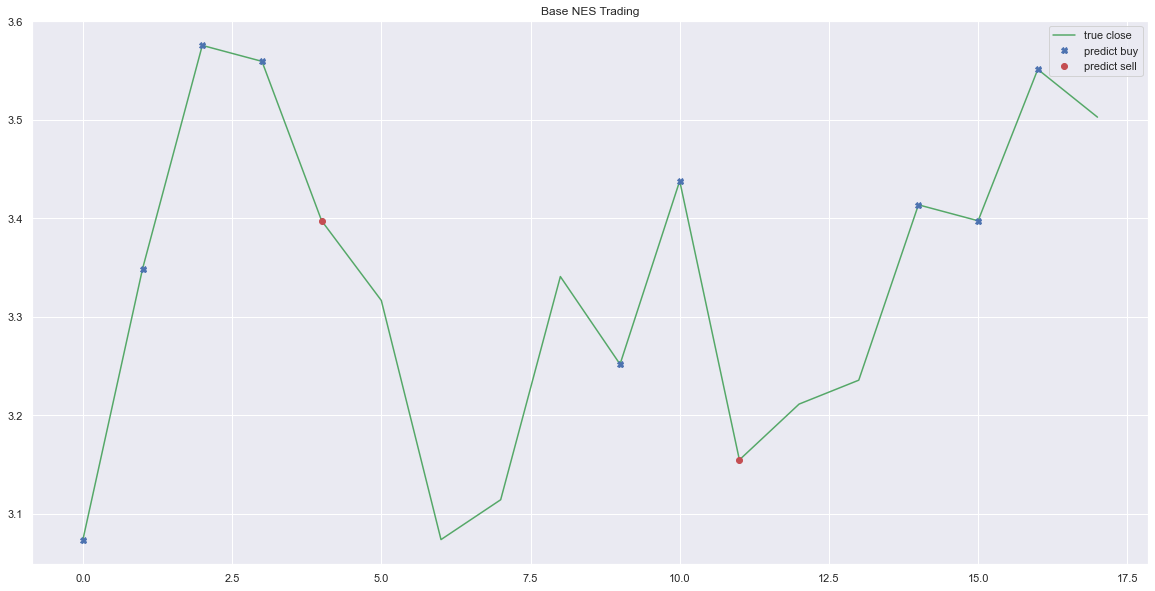

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 13: buy 1 units at price 3.235503, total balance 9996.392414
day 14: buy 1 units at price 3.413455, total balance 9992.978959
day 15: buy 1 units at price 3.397277, total balance 9989.581682
day 16: buy 1 units at price 3.550965, total balance 9986.030717

total gained -13.969283, total investment -0.139693 %


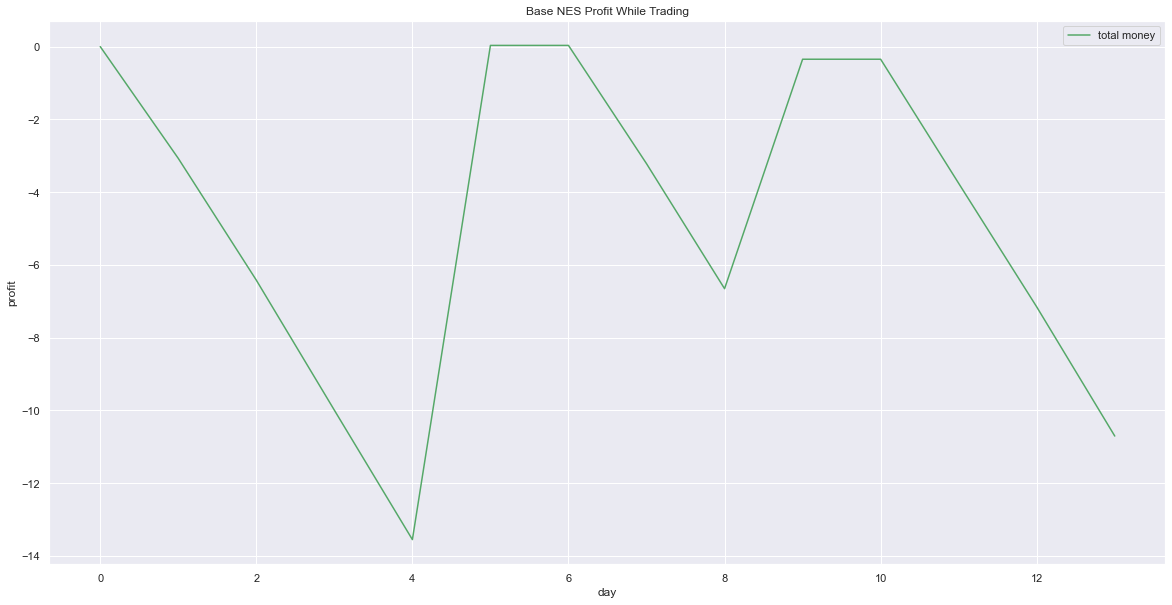

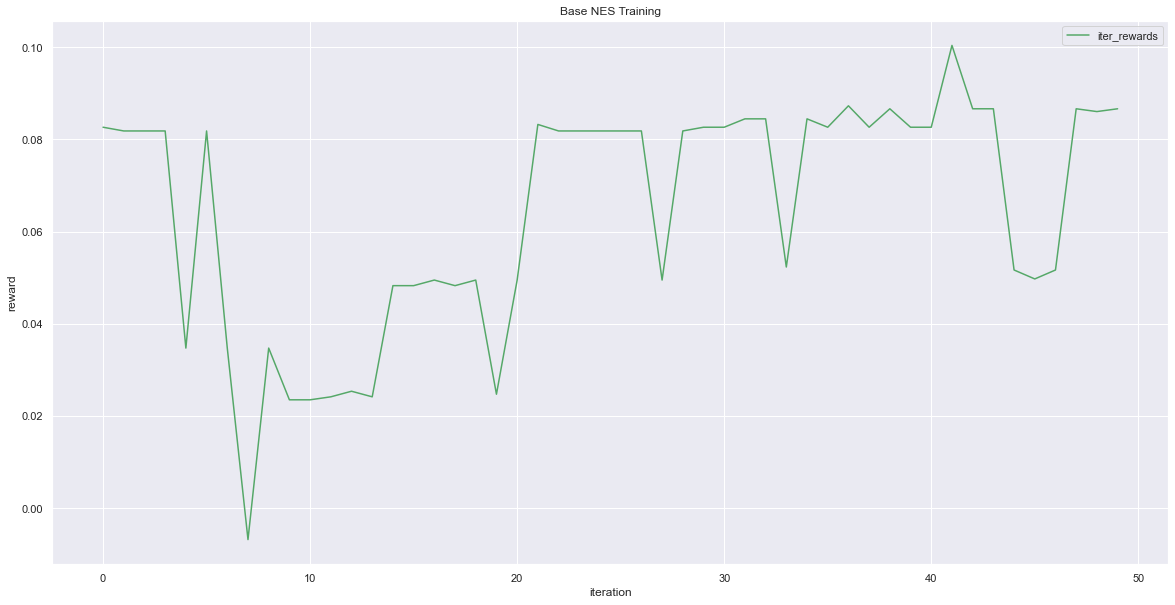

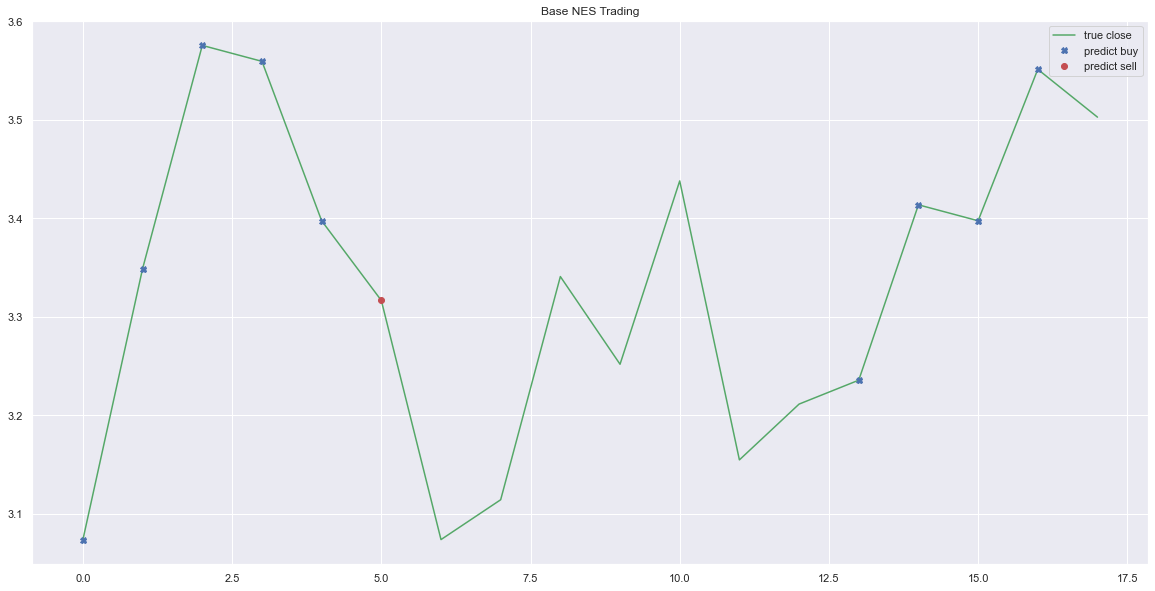

day 0: buy 1 units at price 3.073728, total balance 9996.926272
day 1: buy 1 units at price 3.348745, total balance 9993.577527
day 2: buy 1 units at price 3.575230, total balance 9990.002297
day 3: buy 1 units at price 3.559053, total balance 9986.443244
day 4: buy 1 units at price 3.397277, total balance 9983.045967
day 5, sell 5 units at price 16.581950, investment 439.473564 %, total balance 9999.627917,
day 12: buy 1 units at price 3.211236, total balance 9996.416681
day 13: buy 1 units at price 3.235503, total balance 9993.181178
day 14: buy 1 units at price 3.413455, total balance 9989.767723
day 15: buy 1 units at price 3.397277, total balance 9986.370446
day 16: buy 1 units at price 3.550965, total balance 9982.819481

total gained -17.180519, total investment -0.171805 %


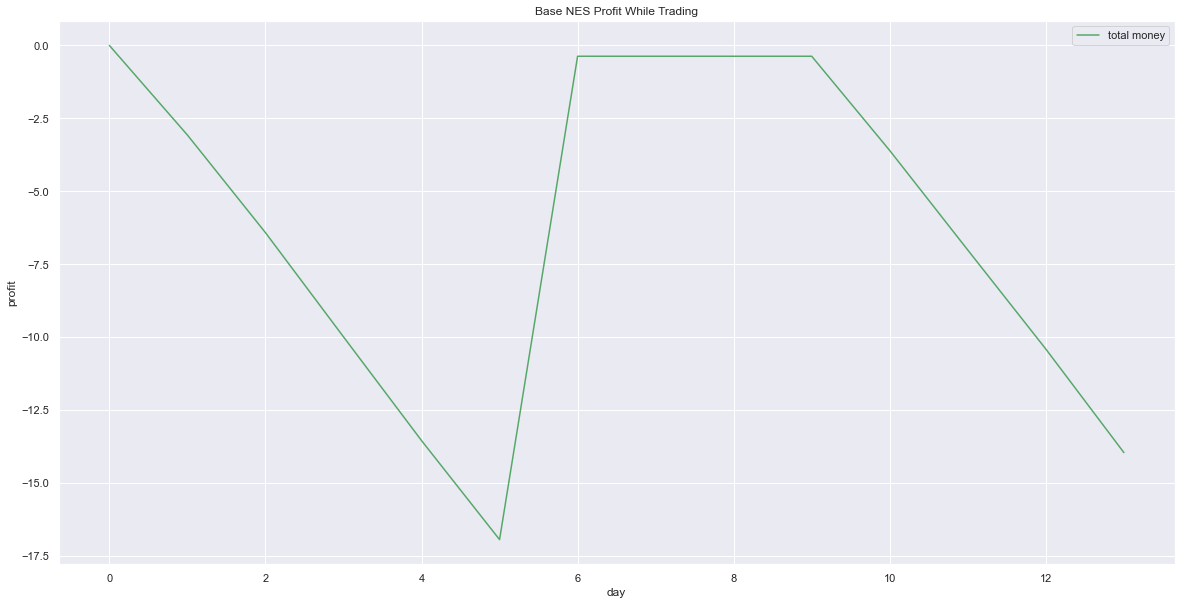

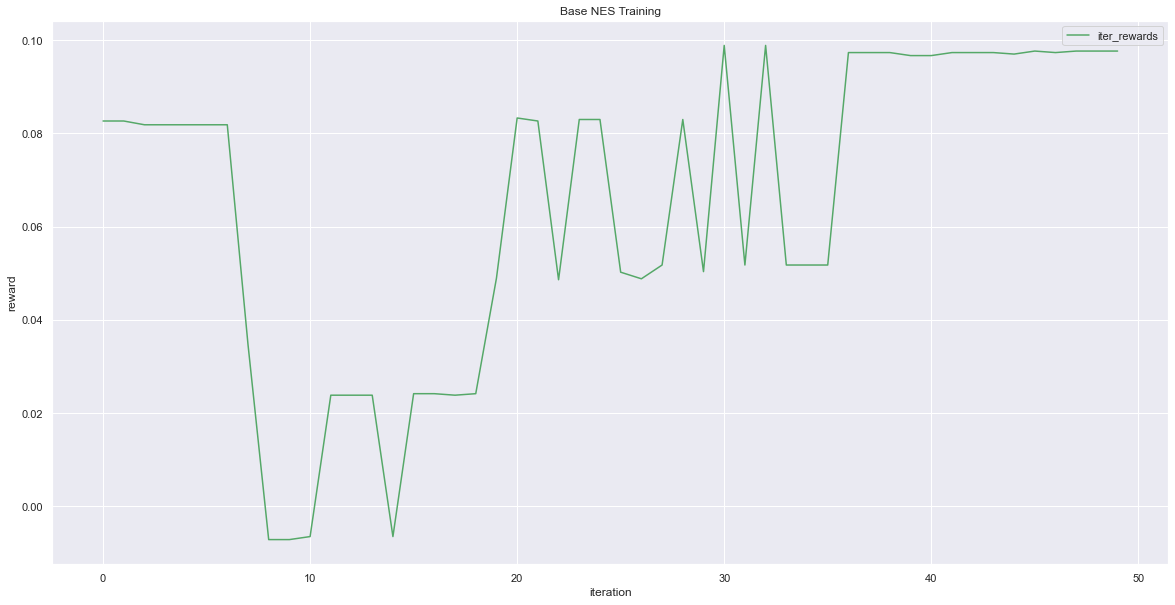

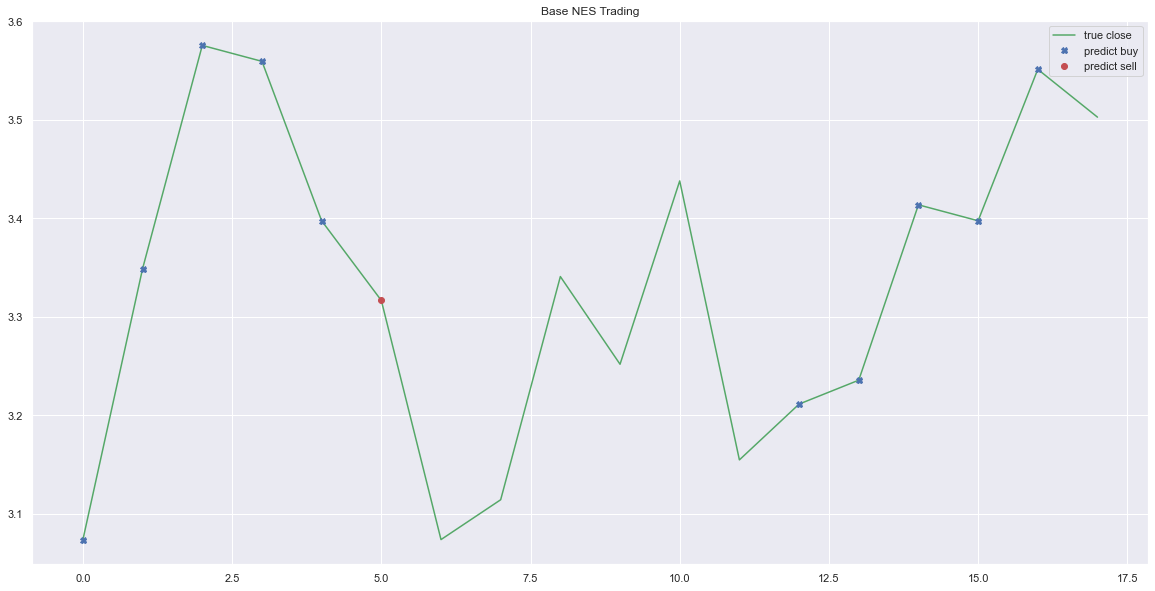

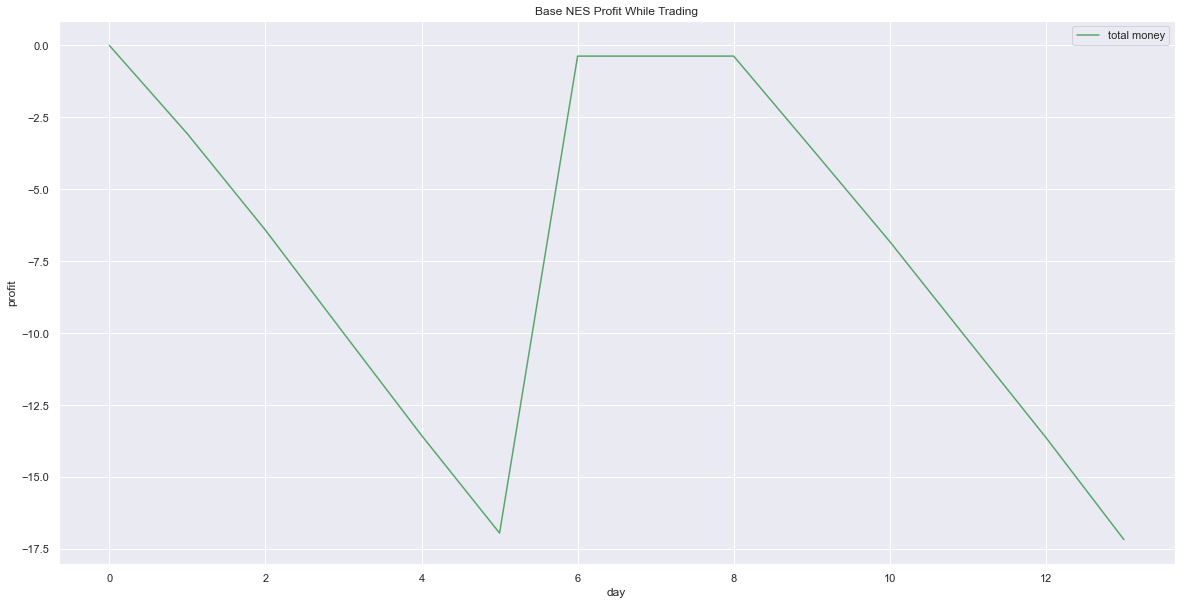

In [12]:
profits = []
labels = []

epoch_rewards = []
track_money = []

for i in range(0,sample_size):
    # Train
    close = t_train.Close.values.tolist()
    model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    agent.fit(iterations = num_iter_test, checkpoint = 10)       
    
    # Train plots
    plt.figure(figsize = (20, 10))
    plt.title("Base NES Training")
    plt.xlabel('iteration')
    plt.ylabel('reward')
    plt.plot(epoch_rewards, label = 'iter_rewards', c = 'g')
    plt.ticklabel_format(style='plain')
    plt.legend()
    saveFig(out_dir, 'train')
#     plt.show()
    writeCSV(out_dir, "train_data", epoch_rewards)
    epoch_rewards = []
    
    #Test
    close = t_test.Close.values.tolist()
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    
    # Test trade (plots trading in agent.but())
    agent.buy()
    profit = agent.get_profit()
    profits.append(profit)
    
    # Profit plots
    plt.figure(figsize = (20, 10))
    plt.ticklabel_format(style='plain')
    plt.title("Base NES Profit While Trading")
    plt.xlabel('day')
    plt.ylabel('profit')
    plt.plot(track_money, label = 'total money', c = 'g')
    plt.legend()
    saveFig(out_dir, 'trade_balance')
#     plt.show()
    writeCSV(out_dir, "profit_data", track_money)
    
    track_money = []
    labels.append(str(i))

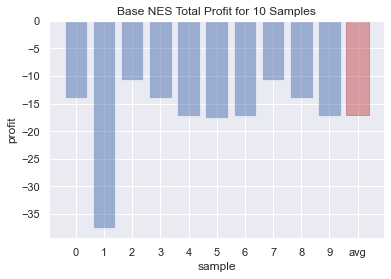

In [13]:
avg_profit = statistics.mean(profits) 
profits.append(avg_profit)
labels.append("avg")
y_pos = np.arange(len(profits))
plt.bar(y_pos, profits, align='center', alpha=0.5)[sample_size].set_color('r')
plt.xticks(y_pos, labels)
plt.ylabel('profit')
plt.xlabel('sample')
plt.title("Base NES Total Profit for " + str(len(profits) - 1) + " Samples")
saveFig(out_dir, 'results')
plt.show()
writeCSV(out_dir,"results_data",profits[:-1])